In [3]:
%config InlineBackend.figure_format = 'retina'

In [4]:
import os
import re
import math
import scvelo as scv
import pickle5 as pkl
import numpy as np
import scanpy as sc
from collections import Counter
from glob import glob
import pandas as pd
from copy import deepcopy
from scipy.stats import pearsonr, ranksums
import matplotlib.pyplot as plt
from pylab import *
from matplotlib import pyplot
import seaborn as sns

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams["font.sans-serif"] = "Arial"

In [5]:
def my_vmax(values): 
    return (np.percentile(values, 99)+np.max(values))/2

In [6]:
scv.set_figure_params(figsize=(5,8), transparent=False, facecolor='white')

In [7]:
indir = '~/decidua/10xVisium/file/new'
scv.settings.figdir = '~/decidua/10xVisium/plot/new/velo'

In [8]:
path = os.path.join(indir,'SPACEL/Normal_crop_coord.pkl')
with open(path, 'rb') as handle:
    coord_dict = pkl.load(handle, )
    
path = os.path.join(indir,'SPACEL/RPL_crop_coord.pkl')
with open(path, 'rb') as handle:
    rpl_coord_dict = pkl.load(handle)
    
coord_dict.update(rpl_coord_dict)

In [9]:
order_ctypes = ['dNKp','dNK1','dNK2','dNK3','dM1','dM2','CD4T','CD8T','Treg',
                'DC','ILC3','dS1','dS2','dS3','Epi','Endo','PV','EVT']

In [ ]:
ad_loom = scv.read('~/decidua/10xVisium/scRNA/nature/combine.loom')

In [ ]:
ad_loom

In [20]:
def run_velo_para(slide, cut_prob=0.05):
    
    path = os.path.join(indir, 'SPACEL', f'{slide}.count.h5ad')
    ad_sp = sc.read_h5ad(path)

    clusters_data = ad_sp.obs[[x+'_abundance' for x in order_ctypes]]
    clusters_data.columns = [x.split('_')[0] for x in clusters_data.columns]

    path = os.path.join(indir, 'Tangram/cell', f'{slide}.cell_map.h5ad')
    ad_map = sc.read_h5ad(path)

    cells_data = pd.DataFrame(ad_map.X, index=ad_map.obs.index, columns=ad_map.var.index)

    ad_sc = sc.read_h5ad('~/decidua/10xVisium/file/to_tangram/Epreg_noFilter.h5ad')
    celltype = ad_sc.obs[['new.type']]
    celltype.columns = ['cell.type2']

    ### 生成最大概率位置为1，其余为0的矩阵，spot与cell对应关系
    max_id = cells_data.values.argmax(axis=1)
    data_new = pd.DataFrame(np.zeros((cells_data.shape[0],cells_data.shape[1])),
                            index=cells_data.index, columns=cells_data.columns)
    for i in range(len(data_new.index.tolist())):
        data_new.iloc[i,max_id[i]] = 1

    ### 生成细胞与细胞类型对应的01矩阵
    celltype = celltype.loc[data_new.index]
    celltype['cell'] = celltype.index
    celltype['value'] = 1
    celltype = celltype.pivot(index='cell',columns='cell.type2',values='value').fillna(0)
    celltype = celltype.loc[data_new.index]

    ### 通过spot*cell dot cell*celltype生成spot*celltype的矩阵，得到spot内是否有该celltype的信息
    spot_ct = np.dot(data_new.T,celltype)
    spot_ct = pd.DataFrame(spot_ct,index=data_new.columns,columns=celltype.columns)

    ### 生成clster模式的01矩阵，celltype中预测概率大于平均的spot为1
    data_new_clusters = pd.DataFrame(np.zeros((clusters_data.shape[0],clusters_data.shape[1])),
                                     index=clusters_data.index,columns=clusters_data.columns)
    clusters_mean = clusters_data.mean(axis=0)

    ##### i为列 j为行
    for i in range(clusters_data.shape[1]):
        for j in range(clusters_data.shape[0]):
            if clusters_data.iloc[j,i] > clusters_mean[i]:
                data_new_clusters.iloc[j,i]=1
    data_new_clusters = data_new_clusters.loc[spot_ct.index]
    data_new_clusters = data_new_clusters.loc[:,spot_ct.columns]

    ### 取spot_ct与data_new_clusters交集为富集spot
    data_filter = np.multiply(spot_ct, data_new_clusters)

    ### 根据data_new得到cell与spot的对应关系 
    data_new['cell'] = data_new.index
    cell_map_spot = data_new.melt(id_vars=['cell'])
    cell_map_spot = cell_map_spot.drop(cell_map_spot[cell_map_spot['value']<1].index)
    del cell_map_spot['value']
    cell_map_spot.columns = ['cell','spot']

    ##### 重新读celltype命名为celltypes 赋给cell_map_spot
    celltypes = ad_sc.obs[['new.type']]
    celltypes.columns = ['cell.type2']

    celltypes = celltypes.loc[cell_map_spot['cell']]
    cell_map_spot['cell_type'] = celltypes['cell.type2'].tolist()

    ### 根据 data_filter 得到细胞类型的过滤器
    data_filter.columns = data_filter.columns.astype(str)
    data_filter['spot'] = data_filter.index
    celltype_filter = data_filter.melt(id_vars=['spot'])
    celltype_filter = celltype_filter.drop(celltype_filter[celltype_filter['value']<1].index)

    ### cell_map_spot按照celltype_filter结果筛选
    cell_map_spot['filter'] = 0
    for i in cell_map_spot.index:
        map_spot = cell_map_spot.loc[i,'spot']
        map_celltype = cell_map_spot.loc[i,'cell_type']
        if map_spot in celltype_filter['spot'].tolist():
            data_celltype_filter = celltype_filter[celltype_filter['spot']==map_spot]
            if map_celltype in data_celltype_filter['cell.type2'].tolist():
                cell_map_spot.loc[i,'filter'] = 1
    cell_map_spot = cell_map_spot.drop(cell_map_spot[cell_map_spot['filter']<1].index)
    del cell_map_spot['filter']
    cell_map_spot = cell_map_spot[['spot','cell','cell_type']]

    decon = deepcopy(cell_map_spot)
    # prob = deepcopy(clusters_data)
    path = os.path.join(indir, 'SPACEL', f'scaled_ctype_proportion.per_spot.{slide}.csv')
    prob = pd.read_csv(path, index_col=0)

    with open('~/decidua/10xVisium/file/'+slide+'_spot_cell_counts.to_tangram.pkl', 'rb') as f:
        meta = pkl.load(f)

    import random

    decon[['x','y']] = 0
    for i in range(len(decon)):
        get_spot = decon.iloc[i,0]
        get_position = meta.loc[get_spot,'cell_position']
        if get_position.shape[0] != 0:
            get_position_id = random.sample(range(len(get_position)),1)[0]
            decon.iloc[i,3] = get_position[get_position_id,0]
            decon.iloc[i,4] = get_position[get_position_id,1]
        else:
            get_position = ad_sp.obs.loc[get_spot,['x','y']]
            decon.iloc[i,3] = get_position[0]
            decon.iloc[i,4] = get_position[1]

    ad_loom_rnav = deepcopy(ad_loom)
    index = [i[0:10]+'_'+i[11:27] for i in ad_loom_rnav.obs.index]
    ad_loom_rnav.obs.index = index
    sel_overlop = [x for x in decon['cell'].tolist() if x in ad_sc.obs.index.tolist()]
    ad_sc = ad_sc[sel_overlop]

    dNK = pd.DataFrame()
    for j in ['dNK1','dNK2','dNK3', 'dNKp']:
        for i in prob.loc[prob.loc[:,j]>cut_prob,:].index:
            spot = decon.loc[decon.loc[:,'spot']==i,:]
            spot_sel = spot.loc[spot.loc[:,'cell_type']==j,:]
            dNK = dNK.append(spot_sel)

    dNK.index = dNK['cell']
    print(slide, cut_prob)
    print(dNK['cell_type'].value_counts())

    dNK.index = dNK['cell']
    adata_dNK = ad_sc[dNK.index,:]
    adata_dNK.obs = dNK
    adata_scv_dNK = scv.utils.merge(adata_dNK, ad_loom_rnav)
    splice_tsne = dNK.loc[:,['x','y']]
    adata_scv_dNK.obsm['X_umap'] = np.array(splice_tsne)

    scv.pp.filter_and_normalize(adata_scv_dNK, min_shared_counts=20, n_top_genes=2000)
    scv.pp.moments(adata_scv_dNK, n_pcs=30, n_neighbors=30)
    scv.tl.velocity(adata_scv_dNK)
    scv.tl.velocity_graph(adata_scv_dNK)

    scv.pl.velocity_embedding_stream(adata_scv_dNK, basis='umap', color='cell_type',
                                     size=25, legend_loc='right margin', alpha=0.7, 
                                     save='dNK.'+str(cut_prob)+'.'+slide+'.png', show=False)
    
    
    dS = pd.DataFrame()
    for j in ['dS1','dS2','dS3']:
        for i in prob.loc[prob.loc[:,j]>cut_prob,:].index:
            spot = decon.loc[decon.loc[:,'spot']==i,:]
            spot_sel = spot.loc[spot.loc[:,'cell_type']==j,:]
            dS = dS.append(spot_sel)
    dS.index = dS['cell']
    adata_dS = ad_sc[dS.index,:]
    adata_dS.obs = dS
    adata_scv_dS = scv.utils.merge(adata_dS, ad_loom_rnav)
    splice_tsne = dS.loc[:,['x','y']]
    adata_scv_dS.obsm['X_umap'] = np.array(splice_tsne)

    sc.pl.umap(adata_scv_dS, color='cell_type',title='', frameon=False,alpha=0.7)
    scv.pp.filter_and_normalize(adata_scv_dS, min_shared_counts=20, n_top_genes=2000)
    scv.pp.moments(adata_scv_dS, n_pcs=30, n_neighbors=30)
    scv.tl.velocity(adata_scv_dS)
    scv.tl.velocity_graph(adata_scv_dS)
    scv.pl.velocity_embedding_stream(adata_scv_dS, basis='umap',color='cell_type',
                                     size=25,legend_loc='right margin', alpha=0.7, 
                                     save='dS.'+str(cut_prob)+'.'+slide+'.png', show=False)
    
    return

In [21]:
# normal_slices = ['A1_N59','B1_N59','C1_N56','D1_N56','C1_N65','D1_N65']
# for cut_prob in [0.001, 0.005, 0.01, 0.03, 0.05, 0.07]:
#     for slide in normal_slices:
#         run_velo_para(slide, cut_prob=cut_prob)

In [23]:
normal_slices = ['A1_N59','B1_N59','C1_N56','D1_N56','C1_N65','D1_N65']
for cut_prob in [0.001, 0.005, 0.01, 0.03, 0.05, 0.07]:
    for slide in normal_slices:
        path = os.path.join('~/decidua/10xVisium/plot/new/velo', f'scvelo_dNK.{cut_prob}.{slide}.png')
        if os.path.exists(path):
            pass
        else:
            print('No')
#             run_velo_para(slide, cut_prob=cut_prob)

In [24]:
scv.settings.figdir = '~/decidua/10xVisium/plot/new/velo/smooth'

In [29]:
def run_velo_para_smooth(slide, cut_prob=0.05):
    
    path = os.path.join(indir, 'SPACEL', f'{slide}.count.h5ad')
    ad_sp = sc.read_h5ad(path)

    clusters_data = ad_sp.obs[[x+'_abundance' for x in order_ctypes]]
    clusters_data.columns = [x.split('_')[0] for x in clusters_data.columns]

    path = os.path.join(indir, 'Tangram/cell', f'{slide}.cell_map.h5ad')
    ad_map = sc.read_h5ad(path)

    cells_data = pd.DataFrame(ad_map.X, index=ad_map.obs.index, columns=ad_map.var.index)

    ad_sc = sc.read_h5ad('~/decidua/10xVisium/file/to_tangram/Epreg_noFilter.h5ad')
    celltype = ad_sc.obs[['new.type']]
    celltype.columns = ['cell.type2']

    ### 生成最大概率位置为1，其余为0的矩阵，spot与cell对应关系
    max_id = cells_data.values.argmax(axis=1)
    data_new = pd.DataFrame(np.zeros((cells_data.shape[0],cells_data.shape[1])),
                            index=cells_data.index, columns=cells_data.columns)
    for i in range(len(data_new.index.tolist())):
        data_new.iloc[i,max_id[i]] = 1

    ### 生成细胞与细胞类型对应的01矩阵
    celltype = celltype.loc[data_new.index]
    celltype['cell'] = celltype.index
    celltype['value'] = 1
    celltype = celltype.pivot(index='cell',columns='cell.type2',values='value').fillna(0)
    celltype = celltype.loc[data_new.index]

    ### 通过spot*cell dot cell*celltype生成spot*celltype的矩阵，得到spot内是否有该celltype的信息
    spot_ct = np.dot(data_new.T,celltype)
    spot_ct = pd.DataFrame(spot_ct,index=data_new.columns,columns=celltype.columns)

    ### 生成clster模式的01矩阵，celltype中预测概率大于平均的spot为1
    data_new_clusters = pd.DataFrame(np.zeros((clusters_data.shape[0],clusters_data.shape[1])),
                                     index=clusters_data.index,columns=clusters_data.columns)
    clusters_mean = clusters_data.mean(axis=0)

    ##### i为列 j为行
    for i in range(clusters_data.shape[1]):
        for j in range(clusters_data.shape[0]):
            if clusters_data.iloc[j,i] > clusters_mean[i]:
                data_new_clusters.iloc[j,i]=1
    data_new_clusters = data_new_clusters.loc[spot_ct.index]
    data_new_clusters = data_new_clusters.loc[:,spot_ct.columns]

    ### 取spot_ct与data_new_clusters交集为富集spot
    data_filter = np.multiply(spot_ct, data_new_clusters)

    ### 根据data_new得到cell与spot的对应关系 
    data_new['cell'] = data_new.index
    cell_map_spot = data_new.melt(id_vars=['cell'])
    cell_map_spot = cell_map_spot.drop(cell_map_spot[cell_map_spot['value']<1].index)
    del cell_map_spot['value']
    cell_map_spot.columns = ['cell','spot']

    ##### 重新读celltype命名为celltypes 赋给cell_map_spot
    celltypes = ad_sc.obs[['new.type']]
    celltypes.columns = ['cell.type2']

    celltypes = celltypes.loc[cell_map_spot['cell']]
    cell_map_spot['cell_type'] = celltypes['cell.type2'].tolist()

    ### 根据 data_filter 得到细胞类型的过滤器
    data_filter.columns = data_filter.columns.astype(str)
    data_filter['spot'] = data_filter.index
    celltype_filter = data_filter.melt(id_vars=['spot'])
    celltype_filter = celltype_filter.drop(celltype_filter[celltype_filter['value']<1].index)

    ### cell_map_spot按照celltype_filter结果筛选
    cell_map_spot['filter'] = 0
    for i in cell_map_spot.index:
        map_spot = cell_map_spot.loc[i,'spot']
        map_celltype = cell_map_spot.loc[i,'cell_type']
        if map_spot in celltype_filter['spot'].tolist():
            data_celltype_filter = celltype_filter[celltype_filter['spot']==map_spot]
            if map_celltype in data_celltype_filter['cell.type2'].tolist():
                cell_map_spot.loc[i,'filter'] = 1
    cell_map_spot = cell_map_spot.drop(cell_map_spot[cell_map_spot['filter']<1].index)
    del cell_map_spot['filter']
    cell_map_spot = cell_map_spot[['spot','cell','cell_type']]

    decon = deepcopy(cell_map_spot)
    # prob = deepcopy(clusters_data)
    path = os.path.join(indir, 'SPACEL', f'scaled_ctype_proportion.per_spot.{slide}.csv')
    prob = pd.read_csv(path, index_col=0)

    with open('~/decidua/10xVisium/file/'+slide+'_spot_cell_counts.to_tangram.pkl', 'rb') as f:
        meta = pkl.load(f)

    import random

    decon[['x','y']] = 0
    for i in range(len(decon)):
        get_spot = decon.iloc[i,0]
        get_position = meta.loc[get_spot,'cell_position']
        if get_position.shape[0] != 0:
            get_position_id = random.sample(range(len(get_position)),1)[0]
            decon.iloc[i,3] = get_position[get_position_id,0]
            decon.iloc[i,4] = get_position[get_position_id,1]
        else:
            get_position = ad_sp.obs.loc[get_spot,['x','y']]
            decon.iloc[i,3] = get_position[0]
            decon.iloc[i,4] = get_position[1]

    ad_loom_rnav = deepcopy(ad_loom)
    index = [i[0:10]+'_'+i[11:27] for i in ad_loom_rnav.obs.index]
    ad_loom_rnav.obs.index = index
    sel_overlop = [x for x in decon['cell'].tolist() if x in ad_sc.obs.index.tolist()]
    ad_sc = ad_sc[sel_overlop]

    dNK = pd.DataFrame()
    for j in ['dNK1','dNK2','dNK3', 'dNKp']:
        for i in prob.loc[prob.loc[:,j]>cut_prob,:].index:
            spot = decon.loc[decon.loc[:,'spot']==i,:]
            spot_sel = spot.loc[spot.loc[:,'cell_type']==j,:]
            dNK = dNK.append(spot_sel)

    dNK.index = dNK['cell']
    print(slide, cut_prob)
    print(dNK['cell_type'].value_counts())

    dNK.index = dNK['cell']
    adata_dNK = ad_sc[dNK.index,:]
    adata_dNK.obs = dNK
    adata_scv_dNK = scv.utils.merge(adata_dNK, ad_loom_rnav)
    splice_tsne = dNK.loc[:,['x','y']]
    adata_scv_dNK.obsm['X_umap'] = np.array(splice_tsne)

    scv.pp.filter_and_normalize(adata_scv_dNK, min_shared_counts=20, n_top_genes=2000)
    scv.pp.moments(adata_scv_dNK, n_pcs=30, n_neighbors=30)
    scv.tl.velocity(adata_scv_dNK)
    scv.tl.velocity_graph(adata_scv_dNK)

    scv.pl.velocity_embedding_stream(adata_scv_dNK, basis='umap', color='cell_type',
                                     size=25, legend_loc='right margin', alpha=0.7, smooth=1,
                                     save='dNK.'+str(cut_prob)+'.'+slide+'.png', show=False)
    
    return

In [28]:
for cut_prob in [0.01, 0.03, 0.05, 0.07]:
    for slide in normal_slices:
        path = os.path.join('~/decidua/10xVisium/plot/new/velo/smooth', f'scvelo_dNK.{cut_prob}.{slide}.png')
        if os.path.exists(path):
            pass
        else:
            run_velo_para_smooth(slide, cut_prob=cut_prob)

A1_N59 0.01
dNK1    2500
dNK2    2485
dNK3     808
dNKp     413
Name: cell_type, dtype: int64
Filtered out 18242 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
computing neighbors
    finished (0:00:01) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:01) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/144 cores)
    finished (0:00:09) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:01) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file /home/yuqiaoni/decidua/10xVisium/plot/new/velo/smooth/scvel

# plot

In [14]:
outdir = '~/decidua/10xVisium/plot/new/RPL'

In [8]:
slide = 'A1_N59'
cut_prob = 0.05

In [9]:
path = os.path.join(indir, 'SPACEL', f'{slide}.count.h5ad')
ad_sp = sc.read_h5ad(path)

clusters_data = ad_sp.obs[[x+'_abundance' for x in order_ctypes]]
clusters_data.columns = [x.split('_')[0] for x in clusters_data.columns]

path = os.path.join(indir, 'Tangram/cell', f'{slide}.cell_map.h5ad')
ad_map = sc.read_h5ad(path)

cells_data = pd.DataFrame(ad_map.X, index=ad_map.obs.index, columns=ad_map.var.index)

ad_sc = sc.read_h5ad('~/decidua/10xVisium/file/to_tangram/Epreg_noFilter.h5ad')
celltype = ad_sc.obs[['new.type']]
celltype.columns = ['cell.type2']

### 生成最大概率位置为1，其余为0的矩阵，spot与cell对应关系
max_id = cells_data.values.argmax(axis=1)
data_new = pd.DataFrame(np.zeros((cells_data.shape[0],cells_data.shape[1])),
                        index=cells_data.index, columns=cells_data.columns)
for i in range(len(data_new.index.tolist())):
    data_new.iloc[i,max_id[i]] = 1

### 生成细胞与细胞类型对应的01矩阵
celltype = celltype.loc[data_new.index]
celltype['cell'] = celltype.index
celltype['value'] = 1
celltype = celltype.pivot(index='cell',columns='cell.type2',values='value').fillna(0)
celltype = celltype.loc[data_new.index]

### 通过spot*cell dot cell*celltype生成spot*celltype的矩阵，得到spot内是否有该celltype的信息
spot_ct = np.dot(data_new.T,celltype)
spot_ct = pd.DataFrame(spot_ct,index=data_new.columns,columns=celltype.columns)

### 生成clster模式的01矩阵，celltype中预测概率大于平均的spot为1
data_new_clusters = pd.DataFrame(np.zeros((clusters_data.shape[0],clusters_data.shape[1])),
                                 index=clusters_data.index,columns=clusters_data.columns)
clusters_mean = clusters_data.mean(axis=0)

##### i为列 j为行
for i in range(clusters_data.shape[1]):
    for j in range(clusters_data.shape[0]):
        if clusters_data.iloc[j,i] > clusters_mean[i]:
            data_new_clusters.iloc[j,i]=1
data_new_clusters = data_new_clusters.loc[spot_ct.index]
data_new_clusters = data_new_clusters.loc[:,spot_ct.columns]

### 取spot_ct与data_new_clusters交集为富集spot
data_filter = np.multiply(spot_ct, data_new_clusters)

### 根据data_new得到cell与spot的对应关系 
data_new['cell'] = data_new.index
cell_map_spot = data_new.melt(id_vars=['cell'])
cell_map_spot = cell_map_spot.drop(cell_map_spot[cell_map_spot['value']<1].index)
del cell_map_spot['value']
cell_map_spot.columns = ['cell','spot']

##### 重新读celltype命名为celltypes 赋给cell_map_spot
celltypes = ad_sc.obs[['new.type']]
celltypes.columns = ['cell.type2']

celltypes = celltypes.loc[cell_map_spot['cell']]
cell_map_spot['cell_type'] = celltypes['cell.type2'].tolist()

### 根据 data_filter 得到细胞类型的过滤器
data_filter.columns = data_filter.columns.astype(str)
data_filter['spot'] = data_filter.index
celltype_filter = data_filter.melt(id_vars=['spot'])
celltype_filter = celltype_filter.drop(celltype_filter[celltype_filter['value']<1].index)

### cell_map_spot按照celltype_filter结果筛选
cell_map_spot['filter'] = 0
for i in cell_map_spot.index:
    map_spot = cell_map_spot.loc[i,'spot']
    map_celltype = cell_map_spot.loc[i,'cell_type']
    if map_spot in celltype_filter['spot'].tolist():
        data_celltype_filter = celltype_filter[celltype_filter['spot']==map_spot]
        if map_celltype in data_celltype_filter['cell.type2'].tolist():
            cell_map_spot.loc[i,'filter'] = 1
cell_map_spot = cell_map_spot.drop(cell_map_spot[cell_map_spot['filter']<1].index)
del cell_map_spot['filter']
cell_map_spot = cell_map_spot[['spot','cell','cell_type']]

decon = deepcopy(cell_map_spot)
# prob = deepcopy(clusters_data)
path = os.path.join(indir, 'SPACEL', f'scaled_ctype_proportion.per_spot.{slide}.csv')
prob = pd.read_csv(path, index_col=0)

with open('~/decidua/10xVisium/file/'+slide+'_spot_cell_counts.to_tangram.pkl', 'rb') as f:
    meta = pkl.load(f)

import random

decon[['x','y']] = 0
for i in range(len(decon)):
    get_spot = decon.iloc[i,0]
    get_position = meta.loc[get_spot,'cell_position']
    if get_position.shape[0] != 0:
        get_position_id = random.sample(range(len(get_position)),1)[0]
        decon.iloc[i,3] = get_position[get_position_id,0]
        decon.iloc[i,4] = get_position[get_position_id,1]
    else:
        get_position = ad_sp.obs.loc[get_spot,['x','y']]
        decon.iloc[i,3] = get_position[0]
        decon.iloc[i,4] = get_position[1]

ad_loom_rnav = deepcopy(ad_loom)
index = [i[0:10]+'_'+i[11:27] for i in ad_loom_rnav.obs.index]
ad_loom_rnav.obs.index = index
sel_overlop = [x for x in decon['cell'].tolist() if x in ad_sc.obs.index.tolist()]
ad_sc = ad_sc[sel_overlop]

dNK = pd.DataFrame()
for j in ['dNK1','dNK2','dNK3', 'dNKp']:
    for i in prob.loc[prob.loc[:,j]>cut_prob,:].index:
        spot = decon.loc[decon.loc[:,'spot']==i,:]
        spot_sel = spot.loc[spot.loc[:,'cell_type']==j,:]
        dNK = dNK.append(spot_sel)

dNK.index = dNK['cell']
print(slide, cut_prob)
print(dNK['cell_type'].value_counts())

dNK.index = dNK['cell']
adata_dNK = ad_sc[dNK.index,:]
adata_dNK.obs = dNK
adata_scv_dNK = scv.utils.merge(adata_dNK, ad_loom_rnav)
splice_tsne = dNK.loc[:,['x','y']]
adata_scv_dNK.obsm['X_umap'] = np.array(splice_tsne)

scv.pp.filter_and_normalize(adata_scv_dNK, min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(adata_scv_dNK, n_pcs=30, n_neighbors=30)
scv.tl.velocity(adata_scv_dNK)
scv.tl.velocity_graph(adata_scv_dNK)

A1_N59 0.05
dNK2    2484
dNK1    2464
dNK3     684
dNKp      92
Name: cell_type, dtype: int64
Filtered out 18653 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
computing neighbors
    finished (0:00:04) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:01) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/144 cores)
or disable the progress bar using `show_progress_bar=False`.
    finished (0:00:07) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


In [ ]:
splice_tsne.index = adata_scv_dNK.obs['cell'].tolist()
splice_tsne.to_csv('~/decidua/scATAC/vhg38/new/celloracle/dNK_cells_map.'+slide+'.csv')

computing velocity embedding
    finished (0:00:02) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


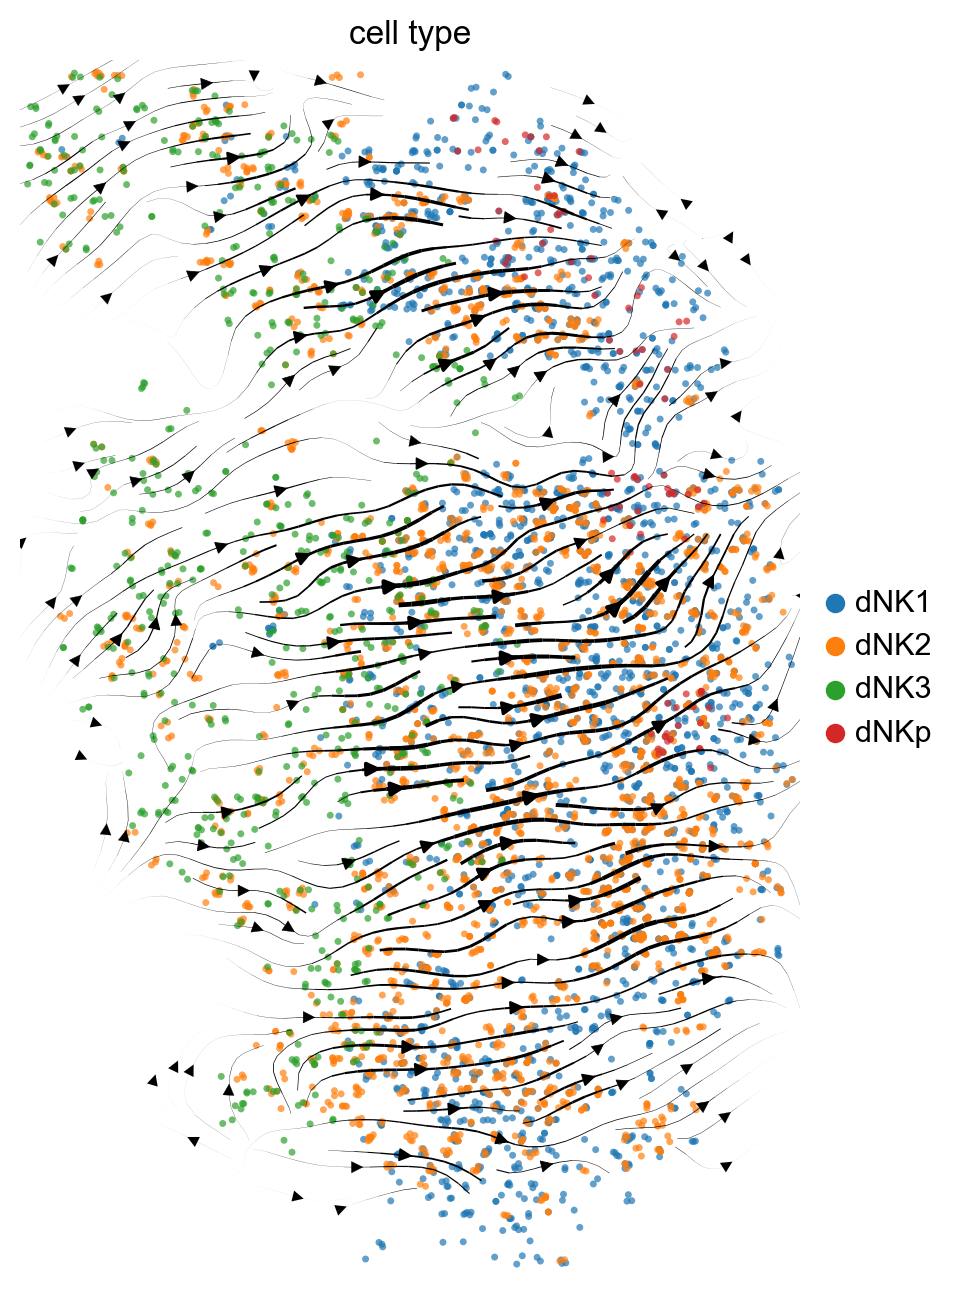

In [10]:
scv.pl.velocity_embedding_stream(adata_scv_dNK, basis='umap', color='cell_type',
                                 size=25, legend_loc='right margin', alpha=0.7, smooth=1)

In [66]:
ctype_dict = {
    'dNK1':3, 'dNK3':2, 'dNK2':1, 'dNKp':0 
}
# ctype_dict = {
#     'dNK1':0, 'dNK3':1, 'dNK2':2, 'dNKp':3 
# }

In [70]:
# clist = ['#a4cec4','#63B472','#2D563D','#edd515']
# cmap = mpl.colors.LinearSegmentedColormap.from_list('mylist', clist, N=256)

In [67]:
# adata_scv_dNK.obs['new_type'] = pd.Categorical(adata_scv_dNK.obs['cell_type'].map(lambda x: ctype_dict[x]), categories=[3,2,1,0])
# adata_scv_dNK.obs['new_type'] = pd.Categorical(adata_scv_dNK.obs['cell_type'].map(lambda x: ctype_dict[x]), categories=[0,1,2,3])

In [88]:
adata_scv_dNK.obs['cell_type'] = pd.Categorical(adata_scv_dNK.obs['cell_type'], categories=['dNKp','dNK1','dNK2','dNK3'])

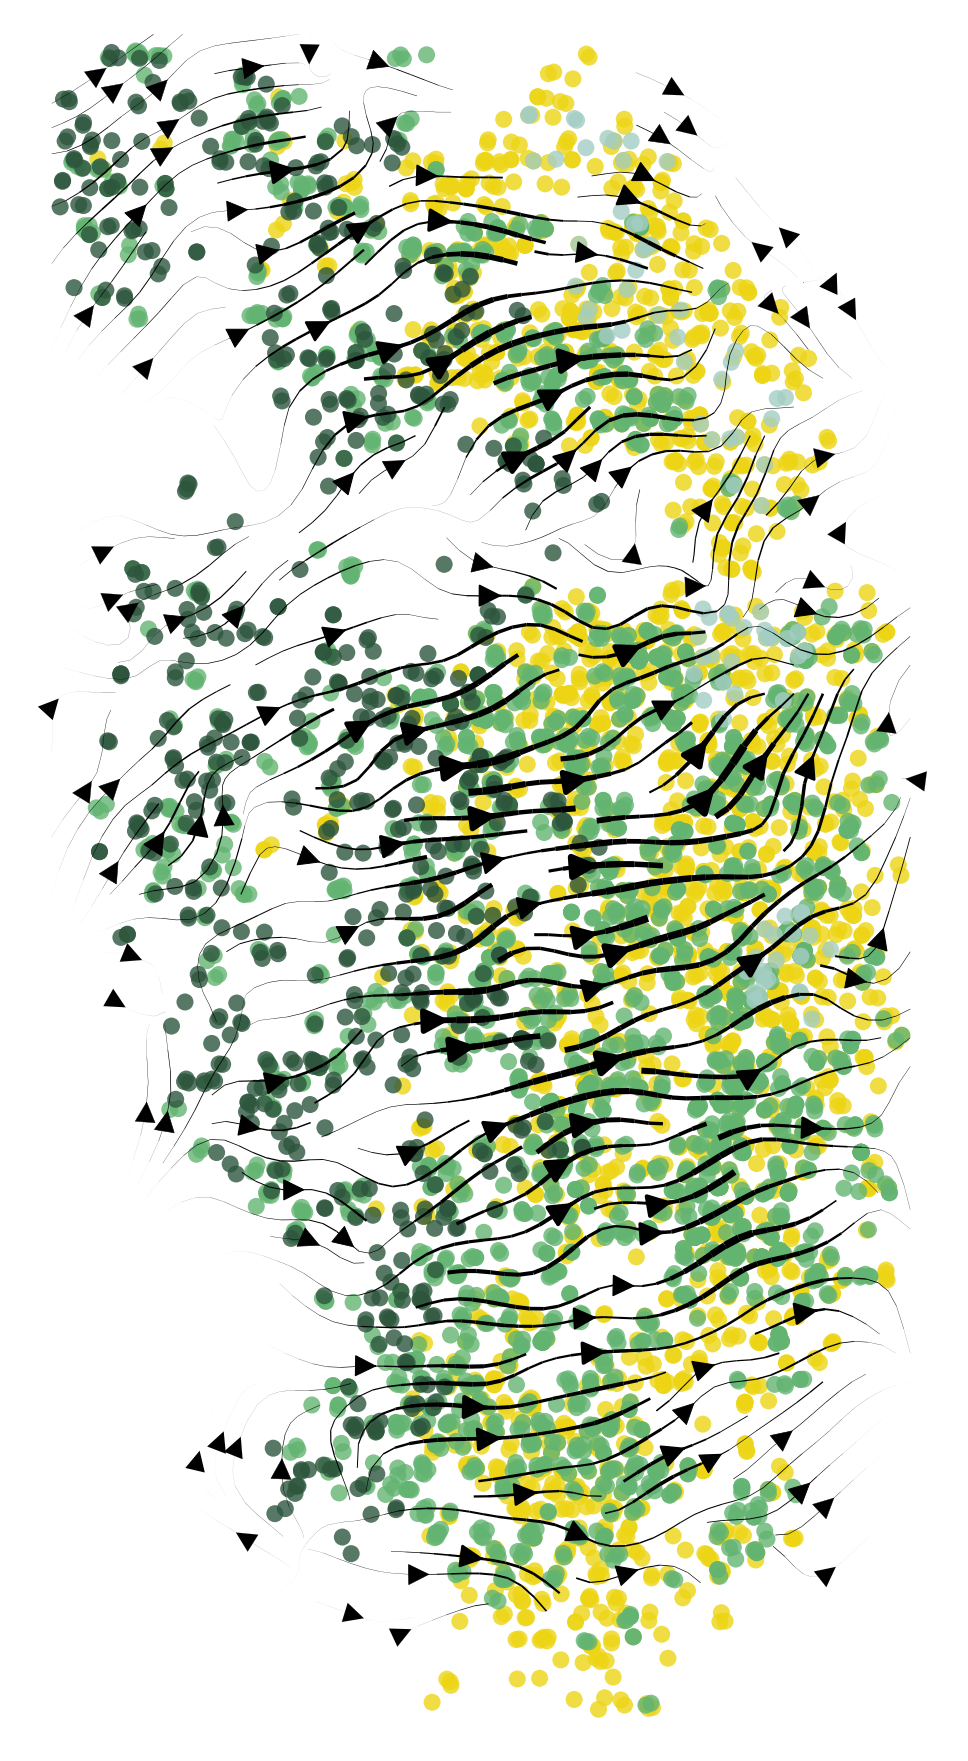

In [94]:
h = 5
plt.figure(figsize=(h, 1.7934*h))
ax21 = plt.subplot(111)
scv.pl.velocity_embedding_stream(adata_scv_dNK, basis='umap', color='cell_type', 
                                 xlim=[coord_dict[slide][2],coord_dict[slide][3]], 
                                 ylim=[coord_dict[slide][0],coord_dict[slide][1]],
                                 size=150, arrow_size=1.8, linewidth=1.5, alpha=0.8, 
                                 palette=['#a4cec4', '#edd515','#63B472','#2D563D'], 
                                 title='', legend_loc='right margin', smooth=1,
                                 ax=ax21, show=False, dpi=1000)
ax21.get_legend().remove()
plt.tight_layout()
plt.savefig(outdir+'/'+slide+'_scvelo.png', dpi=1000)

In [95]:
slide = 'D1_N65'
cut_prob = 0.05

In [96]:
path = os.path.join(indir, 'SPACEL', f'{slide}.count.h5ad')
ad_sp = sc.read_h5ad(path)

clusters_data = ad_sp.obs[[x+'_abundance' for x in order_ctypes]]
clusters_data.columns = [x.split('_')[0] for x in clusters_data.columns]

path = os.path.join(indir, 'Tangram/cell', f'{slide}.cell_map.h5ad')
ad_map = sc.read_h5ad(path)

cells_data = pd.DataFrame(ad_map.X, index=ad_map.obs.index, columns=ad_map.var.index)

ad_sc = sc.read_h5ad('~/decidua/10xVisium/file/to_tangram/Epreg_noFilter.h5ad')
celltype = ad_sc.obs[['new.type']]
celltype.columns = ['cell.type2']

### 生成最大概率位置为1，其余为0的矩阵，spot与cell对应关系
max_id = cells_data.values.argmax(axis=1)
data_new = pd.DataFrame(np.zeros((cells_data.shape[0],cells_data.shape[1])),
                        index=cells_data.index, columns=cells_data.columns)
for i in range(len(data_new.index.tolist())):
    data_new.iloc[i,max_id[i]] = 1

### 生成细胞与细胞类型对应的01矩阵
celltype = celltype.loc[data_new.index]
celltype['cell'] = celltype.index
celltype['value'] = 1
celltype = celltype.pivot(index='cell',columns='cell.type2',values='value').fillna(0)
celltype = celltype.loc[data_new.index]

### 通过spot*cell dot cell*celltype生成spot*celltype的矩阵，得到spot内是否有该celltype的信息
spot_ct = np.dot(data_new.T,celltype)
spot_ct = pd.DataFrame(spot_ct,index=data_new.columns,columns=celltype.columns)

### 生成clster模式的01矩阵，celltype中预测概率大于平均的spot为1
data_new_clusters = pd.DataFrame(np.zeros((clusters_data.shape[0],clusters_data.shape[1])),
                                 index=clusters_data.index,columns=clusters_data.columns)
clusters_mean = clusters_data.mean(axis=0)

##### i为列 j为行
for i in range(clusters_data.shape[1]):
    for j in range(clusters_data.shape[0]):
        if clusters_data.iloc[j,i] > clusters_mean[i]:
            data_new_clusters.iloc[j,i]=1
data_new_clusters = data_new_clusters.loc[spot_ct.index]
data_new_clusters = data_new_clusters.loc[:,spot_ct.columns]

### 取spot_ct与data_new_clusters交集为富集spot
data_filter = np.multiply(spot_ct, data_new_clusters)

### 根据data_new得到cell与spot的对应关系 
data_new['cell'] = data_new.index
cell_map_spot = data_new.melt(id_vars=['cell'])
cell_map_spot = cell_map_spot.drop(cell_map_spot[cell_map_spot['value']<1].index)
del cell_map_spot['value']
cell_map_spot.columns = ['cell','spot']

##### 重新读celltype命名为celltypes 赋给cell_map_spot
celltypes = ad_sc.obs[['new.type']]
celltypes.columns = ['cell.type2']

celltypes = celltypes.loc[cell_map_spot['cell']]
cell_map_spot['cell_type'] = celltypes['cell.type2'].tolist()

### 根据 data_filter 得到细胞类型的过滤器
data_filter.columns = data_filter.columns.astype(str)
data_filter['spot'] = data_filter.index
celltype_filter = data_filter.melt(id_vars=['spot'])
celltype_filter = celltype_filter.drop(celltype_filter[celltype_filter['value']<1].index)

### cell_map_spot按照celltype_filter结果筛选
cell_map_spot['filter'] = 0
for i in cell_map_spot.index:
    map_spot = cell_map_spot.loc[i,'spot']
    map_celltype = cell_map_spot.loc[i,'cell_type']
    if map_spot in celltype_filter['spot'].tolist():
        data_celltype_filter = celltype_filter[celltype_filter['spot']==map_spot]
        if map_celltype in data_celltype_filter['cell.type2'].tolist():
            cell_map_spot.loc[i,'filter'] = 1
cell_map_spot = cell_map_spot.drop(cell_map_spot[cell_map_spot['filter']<1].index)
del cell_map_spot['filter']
cell_map_spot = cell_map_spot[['spot','cell','cell_type']]

decon = deepcopy(cell_map_spot)
# prob = deepcopy(clusters_data)
path = os.path.join(indir, 'SPACEL', f'scaled_ctype_proportion.per_spot.{slide}.csv')
prob = pd.read_csv(path, index_col=0)

with open('~/decidua/10xVisium/file/'+slide+'_spot_cell_counts.to_tangram.pkl', 'rb') as f:
    meta = pkl.load(f)

import random

decon[['x','y']] = 0
for i in range(len(decon)):
    get_spot = decon.iloc[i,0]
    get_position = meta.loc[get_spot,'cell_position']
    if get_position.shape[0] != 0:
        get_position_id = random.sample(range(len(get_position)),1)[0]
        decon.iloc[i,3] = get_position[get_position_id,0]
        decon.iloc[i,4] = get_position[get_position_id,1]
    else:
        get_position = ad_sp.obs.loc[get_spot,['x','y']]
        decon.iloc[i,3] = get_position[0]
        decon.iloc[i,4] = get_position[1]

ad_loom_rnav = deepcopy(ad_loom)
index = [i[0:10]+'_'+i[11:27] for i in ad_loom_rnav.obs.index]
ad_loom_rnav.obs.index = index
sel_overlop = [x for x in decon['cell'].tolist() if x in ad_sc.obs.index.tolist()]
ad_sc = ad_sc[sel_overlop]

dNK = pd.DataFrame()
for j in ['dNK1','dNK2','dNK3', 'dNKp']:
    for i in prob.loc[prob.loc[:,j]>cut_prob,:].index:
        spot = decon.loc[decon.loc[:,'spot']==i,:]
        spot_sel = spot.loc[spot.loc[:,'cell_type']==j,:]
        dNK = dNK.append(spot_sel)

dNK.index = dNK['cell']
print(slide, cut_prob)
print(dNK['cell_type'].value_counts())

dNK.index = dNK['cell']
adata_dNK = ad_sc[dNK.index,:]
adata_dNK.obs = dNK
adata_scv_dNK = scv.utils.merge(adata_dNK, ad_loom_rnav)
splice_tsne = dNK.loc[:,['x','y']]
adata_scv_dNK.obsm['X_umap'] = np.array(splice_tsne)

scv.pp.filter_and_normalize(adata_scv_dNK, min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(adata_scv_dNK, n_pcs=30, n_neighbors=30)
scv.tl.velocity(adata_scv_dNK)
scv.tl.velocity_graph(adata_scv_dNK)

D1_N65 0.05
dNK1    2494
dNK2    1905
dNK3     439
dNKp      78
Name: cell_type, dtype: int64
Filtered out 18912 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:01) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/144 cores)
    finished (0:00:07) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


In [97]:
adata_scv_dNK.obs['cell_type'] = pd.Categorical(adata_scv_dNK.obs['cell_type'], categories=['dNKp','dNK1','dNK2','dNK3'])

In [102]:
coord_dict[slide]

[1242.5, 13940.5, 5550.5, 13350.5]

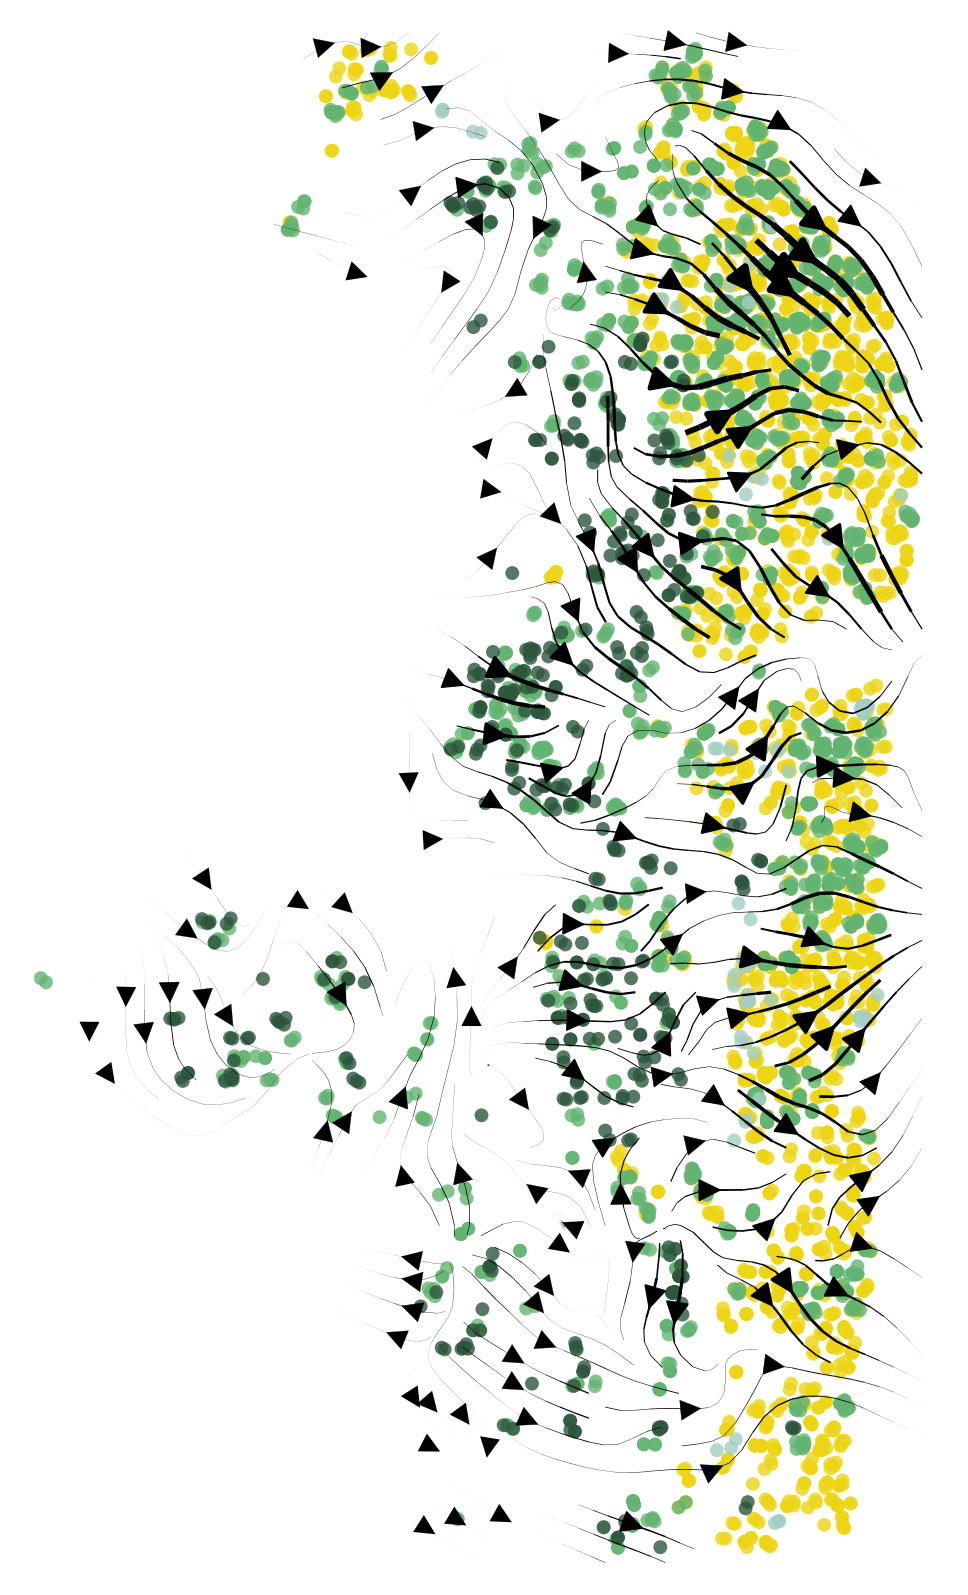

In [109]:
h = 5
plt.figure(figsize=(h, 1.62795*h))
ax21 = plt.subplot(111)
scv.pl.velocity_embedding_stream(adata_scv_dNK, basis='umap', color='cell_type', 
                                 xlim=[coord_dict[slide][2]-4000,coord_dict[slide][3]-4000], 
                                 ylim=[coord_dict[slide][0],coord_dict[slide][1]],
                                 size=100, arrow_size=1.8, linewidth=1.5, alpha=0.8, 
                                 palette=['#a4cec4', '#edd515','#63B472','#2D563D'], 
                                 title='', legend_loc='right margin', smooth=1,
                                 ax=ax21, show=False, dpi=1000)
ax21.get_legend().remove()
plt.tight_layout()
# plt.savefig(outdir+'/'+slide+'_scvelo.png', dpi=1000)

In [118]:
spot_domain_dict = dict(zip(ad_sp.obs.index, ad_sp.obs['Domain']))

In [121]:
adata_scv_dNK.obs['Domain'] = adata_scv_dNK.obs['spot'].map(spot_domain_dict)

In [129]:
adata_scv_dNK.obs['new_type'] = 'dnk_domain2'
adata_scv_dNK.obs.loc[adata_scv_dNK.obs['Domain']=='Domain1','new_type'] = 'other_dnk_domain1'
adata_scv_dNK.obs.loc[(adata_scv_dNK.obs['Domain']=='Domain1') & (adata_scv_dNK.obs['cell_type']=='dNK1'),'new_type'] = 'dnk1_domain1'

In [130]:
scv.tl.paga(adata_scv_dNK, groups='cell_type')
df = scv.get_df(adata_scv_dNK, 'paga/transitions_confidence', precision=2).T
df.style.background_gradient(cmap='Blues').format('{:.2g}')

running PAGA using priors: ['velocity_pseudotime']
    finished (0:00:01) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)


,dNKp,dNK1,dNK2,dNK3
dNKp,0,0,0.068,0
dNK1,0,0,0,0
dNK2,0,0.21,0,0.029
dNK3,0,0,0,0


In [131]:
scv.tl.paga(adata_scv_dNK, groups='Domain')
df = scv.get_df(adata_scv_dNK, 'paga/transitions_confidence', precision=2).T
df.style.background_gradient(cmap='Blues').format('{:.2g}')

running PAGA using priors: ['velocity_pseudotime']
    finished (0:00:01) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)


,Domain1,Domain2
Domain1,0,0
Domain2,0.083,0


In [132]:
scv.tl.paga(adata_scv_dNK, groups='new_type')
df = scv.get_df(adata_scv_dNK, 'paga/transitions_confidence', precision=2).T
df.style.background_gradient(cmap='Blues').format('{:.2g}')

running PAGA using priors: ['velocity_pseudotime']
    finished (0:00:01) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)


,dnk1_domain1,dnk_domain2,other_dnk_domain1
dnk1_domain1,0,0,0
dnk_domain2,0,0,0
other_dnk_domain1,0.2,0.014,0


# paga

In [9]:
def run_paga(slide):
    cut_prob = 0.05
    
    path = os.path.join(indir, 'SPACEL', f'{slide}.count.h5ad')
    ad_sp = sc.read_h5ad(path)

    clusters_data = ad_sp.obs[[x+'_abundance' for x in order_ctypes]]
    clusters_data.columns = [x.split('_')[0] for x in clusters_data.columns]

    path = os.path.join(indir, 'Tangram/cell', f'{slide}.cell_map.h5ad')
    ad_map = sc.read_h5ad(path)

    cells_data = pd.DataFrame(ad_map.X, index=ad_map.obs.index, columns=ad_map.var.index)

    ad_sc = sc.read_h5ad('~/decidua/10xVisium/file/to_tangram/Epreg_noFilter.h5ad')
    celltype = ad_sc.obs[['new.type']]
    celltype.columns = ['cell.type2']

    ### 生成最大概率位置为1，其余为0的矩阵，spot与cell对应关系
    max_id = cells_data.values.argmax(axis=1)
    data_new = pd.DataFrame(np.zeros((cells_data.shape[0],cells_data.shape[1])),
                            index=cells_data.index, columns=cells_data.columns)
    for i in range(len(data_new.index.tolist())):
        data_new.iloc[i,max_id[i]] = 1

    ### 生成细胞与细胞类型对应的01矩阵
    celltype = celltype.loc[data_new.index]
    celltype['cell'] = celltype.index
    celltype['value'] = 1
    celltype = celltype.pivot(index='cell',columns='cell.type2',values='value').fillna(0)
    celltype = celltype.loc[data_new.index]

    ### 通过spot*cell dot cell*celltype生成spot*celltype的矩阵，得到spot内是否有该celltype的信息
    spot_ct = np.dot(data_new.T,celltype)
    spot_ct = pd.DataFrame(spot_ct,index=data_new.columns,columns=celltype.columns)

    ### 生成clster模式的01矩阵，celltype中预测概率大于平均的spot为1
    data_new_clusters = pd.DataFrame(np.zeros((clusters_data.shape[0],clusters_data.shape[1])),
                                     index=clusters_data.index,columns=clusters_data.columns)
    clusters_mean = clusters_data.mean(axis=0)

    ##### i为列 j为行
    for i in range(clusters_data.shape[1]):
        for j in range(clusters_data.shape[0]):
            if clusters_data.iloc[j,i] > clusters_mean[i]:
                data_new_clusters.iloc[j,i]=1
    data_new_clusters = data_new_clusters.loc[spot_ct.index]
    data_new_clusters = data_new_clusters.loc[:,spot_ct.columns]

    ### 取spot_ct与data_new_clusters交集为富集spot
    data_filter = np.multiply(spot_ct, data_new_clusters)

    ### 根据data_new得到cell与spot的对应关系 
    data_new['cell'] = data_new.index
    cell_map_spot = data_new.melt(id_vars=['cell'])
    cell_map_spot = cell_map_spot.drop(cell_map_spot[cell_map_spot['value']<1].index)
    del cell_map_spot['value']
    cell_map_spot.columns = ['cell','spot']

    ##### 重新读celltype命名为celltypes 赋给cell_map_spot
    celltypes = ad_sc.obs[['new.type']]
    celltypes.columns = ['cell.type2']

    celltypes = celltypes.loc[cell_map_spot['cell']]
    cell_map_spot['cell_type'] = celltypes['cell.type2'].tolist()

    ### 根据 data_filter 得到细胞类型的过滤器
    data_filter.columns = data_filter.columns.astype(str)
    data_filter['spot'] = data_filter.index
    celltype_filter = data_filter.melt(id_vars=['spot'])
    celltype_filter = celltype_filter.drop(celltype_filter[celltype_filter['value']<1].index)

    ### cell_map_spot按照celltype_filter结果筛选
    cell_map_spot['filter'] = 0
    for i in cell_map_spot.index:
        map_spot = cell_map_spot.loc[i,'spot']
        map_celltype = cell_map_spot.loc[i,'cell_type']
        if map_spot in celltype_filter['spot'].tolist():
            data_celltype_filter = celltype_filter[celltype_filter['spot']==map_spot]
            if map_celltype in data_celltype_filter['cell.type2'].tolist():
                cell_map_spot.loc[i,'filter'] = 1
    cell_map_spot = cell_map_spot.drop(cell_map_spot[cell_map_spot['filter']<1].index)
    del cell_map_spot['filter']
    cell_map_spot = cell_map_spot[['spot','cell','cell_type']]

    decon = deepcopy(cell_map_spot)
    # prob = deepcopy(clusters_data)
    path = os.path.join(indir, 'SPACEL', f'scaled_ctype_proportion.per_spot.{slide}.csv')
    prob = pd.read_csv(path, index_col=0)

    with open('~/decidua/10xVisium/file/'+slide+'_spot_cell_counts.to_tangram.pkl', 'rb') as f:
        meta = pkl.load(f)

    import random

    decon[['x','y']] = 0
    for i in range(len(decon)):
        get_spot = decon.iloc[i,0]
        get_position = meta.loc[get_spot,'cell_position']
        if get_position.shape[0] != 0:
            get_position_id = random.sample(range(len(get_position)),1)[0]
            decon.iloc[i,3] = get_position[get_position_id,0]
            decon.iloc[i,4] = get_position[get_position_id,1]
        else:
            get_position = ad_sp.obs.loc[get_spot,['x','y']]
            decon.iloc[i,3] = get_position[0]
            decon.iloc[i,4] = get_position[1]

    ad_loom_rnav = deepcopy(ad_loom)
    index = [i[0:10]+'_'+i[11:27] for i in ad_loom_rnav.obs.index]
    ad_loom_rnav.obs.index = index
    sel_overlop = [x for x in decon['cell'].tolist() if x in ad_sc.obs.index.tolist()]
    ad_sc = ad_sc[sel_overlop]

    dNK = pd.DataFrame()
    for j in ['dNK1','dNK2','dNK3', 'dNKp']:
        for i in prob.loc[prob.loc[:,j]>cut_prob,:].index:
            spot = decon.loc[decon.loc[:,'spot']==i,:]
            spot_sel = spot.loc[spot.loc[:,'cell_type']==j,:]
            dNK = dNK.append(spot_sel)

    dNK.index = dNK['cell']
    print(slide, cut_prob)
    print(dNK['cell_type'].value_counts())

    dNK.index = dNK['cell']
    adata_dNK = ad_sc[dNK.index,:]
    adata_dNK.obs = dNK
    adata_scv_dNK = scv.utils.merge(adata_dNK, ad_loom_rnav)
    splice_tsne = dNK.loc[:,['x','y']]
    adata_scv_dNK.obsm['X_umap'] = np.array(splice_tsne)

    scv.pp.filter_and_normalize(adata_scv_dNK, min_shared_counts=20, n_top_genes=2000)
    scv.pp.moments(adata_scv_dNK, n_pcs=30, n_neighbors=30)
    scv.tl.velocity(adata_scv_dNK)
    scv.tl.velocity_graph(adata_scv_dNK)
    
    spot_domain_dict = dict(zip(ad_sp.obs.index, ad_sp.obs['Domain']))

    adata_scv_dNK.obs['Domain'] = adata_scv_dNK.obs['spot'].map(spot_domain_dict)

    adata_scv_dNK.obs['new_type'] = 'dnk_domain2'
    adata_scv_dNK.obs.loc[adata_scv_dNK.obs['Domain']=='Domain1','new_type'] = 'other_dnk_domain1'
    adata_scv_dNK.obs.loc[(adata_scv_dNK.obs['Domain']=='Domain1') & (adata_scv_dNK.obs['cell_type']=='dNK1'),'new_type'] = 'dnk1_domain1'

    scv.tl.paga(adata_scv_dNK, groups='cell_type')
    df = scv.get_df(adata_scv_dNK, 'paga/transitions_confidence', precision=2).T
    df.to_csv(indir+'/velo/ctype_paga.'+slide+'.csv')

    scv.tl.paga(adata_scv_dNK, groups='Domain')
    df = scv.get_df(adata_scv_dNK, 'paga/transitions_confidence', precision=2).T
    df.to_csv(indir+'/velo/domain_paga.'+slide+'.csv')

    scv.tl.paga(adata_scv_dNK, groups='new_type')
    df = scv.get_df(adata_scv_dNK, 'paga/transitions_confidence', precision=2).T
    df.to_csv(indir+'/velo/ctype_domain_paga.'+slide+'.csv')
    
    adata_scv_dNK.obs['new_type2'] = 'other'
    adata_scv_dNK.obs.loc[(adata_scv_dNK.obs['Domain']=='Domain1') & (adata_scv_dNK.obs['cell_type']=='dNK1'),'new_type2'] = 'dnk1_domain1'
    adata_scv_dNK.obs.loc[(adata_scv_dNK.obs['Domain']=='Domain1') & (adata_scv_dNK.obs['cell_type']=='dNK2'),'new_type2'] = 'dnk2_domain1'
    adata_scv_dNK.obs.loc[(adata_scv_dNK.obs['Domain']=='Domain2') & (adata_scv_dNK.obs['cell_type']=='dNK2'),'new_type2'] = 'dnk2_domain2'
    adata_scv_dNK.obs.loc[(adata_scv_dNK.obs['Domain']=='Domain2') & (adata_scv_dNK.obs['cell_type']=='dNK3'),'new_type2'] = 'dnk3_domain2'

    scv.tl.paga(adata_scv_dNK, groups='new_type2')
    df = scv.get_df(adata_scv_dNK, 'paga/transitions_confidence', precision=2).T
    df.columns = adata_scv_dNK.obs['new_type2'].cat.categories.tolist()
    df.index = adata_scv_dNK.obs['new_type2'].cat.categories.tolist()
    df.to_csv(indir+'/velo/ctype_domain_paga2.'+slide+'.csv')
    
    
    adata_scv_dNK.write(indir+'/velo/'+slide+'.scvelo.h5ad')
    
    return

In [10]:
normal_slices = ['A1_N59','B1_N59','C1_N56','D1_N56','C1_N65','D1_N65']
for slide in normal_slices:
    run_paga(slide)

A1_N59 0.05
dNK2    2484
dNK1    2464
dNK3     684
dNKp      92
Name: cell_type, dtype: int64
Filtered out 18653 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
computing neighbors
    finished (0:00:04) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:01) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/144 cores)
or disable the progress bar using `show_progress_bar=False`.
    finished (0:00:07) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing terminal states
    identified 4 regions of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells

... storing 'spot' as categorical


    finished (0:00:01) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)
B1_N59 0.05
dNK1    2511
dNK2    1960
dNK3     548
dNKp     215
Name: cell_type, dtype: int64
Filtered out 18749 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
computing neighbors
    finished (0:00:03) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:03) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/144 cores)
    finished (0:00:09) --> added 
    'velocity_graph', sparse matrix with cos

... storing 'spot' as categorical


    finished (0:00:01) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)
C1_N56 0.05
dNK1    2294
dNK2    1372
dNK3     428
dNKp     180
Name: cell_type, dtype: int64
Filtered out 19081 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
computing neighbors
    finished (0:00:01) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/144 cores)
    finished (0:00:05) --> added 
    'velocity_graph', sparse matrix with cos

... storing 'spot' as categorical


    finished (0:00:01) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)
D1_N56 0.05
dNK1    2317
dNK2    1404
dNK3     526
dNKp     182
Name: cell_type, dtype: int64
Filtered out 19047 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
computing neighbors
    finished (0:00:01) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/144 cores)
    finished (0:00:07) --> added 
    'velocity_graph', sparse matrix with cos

... storing 'spot' as categorical


    finished (0:00:01) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)
C1_N65 0.05
dNK1    2538
dNK2    1537
dNK3     422
dNKp     172
Name: cell_type, dtype: int64
Filtered out 18966 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
computing neighbors
    finished (0:00:01) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/144 cores)
    finished (0:00:07) --> added 
    'velocity_graph', sparse matrix with cos

... storing 'spot' as categorical


    finished (0:00:01) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)
D1_N65 0.05
dNK1    2494
dNK2    1905
dNK3     439
dNKp      78
Name: cell_type, dtype: int64
Filtered out 18912 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/144 cores)
    finished (0:00:07) --> added 
    'velocity_graph', sparse matrix with cos

... storing 'spot' as categorical


    finished (0:00:01) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)
